In [1]:
import pandas as pd
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import glob
from tqdm import tqdm

# 1. Introduction

This project is focused on building a movie recommendation system using collaborative filtering techniques. We have created recommender systems using singular value decomposition (SVD) and k-nearest neighbors (KNN).  The main goal is to provide personalized recommendations to users based on their past movie preferences and ratings.

The dataset used in this project contains information about customer ratings for a large number of movies. At first data was pre-processed followed by Exploratory Data Analysis (EDA). Then we created a train/test and validation split for each movie in the dataset. 

For SVD recommender, we used the train set to train a matrix factorization model using singular value decomposition (SVD). We then create a recommender system that is based on movie-similarity to recomended top 5 movies to user based on their most recent and highest rated movie.

For the KNN recommender, we reduced the dimensionality of the user-movie matrix using SVD. Using this reduced matrix, we create a recommender system that is based on user-similarity (in contrast to movie-similarity), and recommends movies to users based on the ratings of similar users and their rating history.

Finally, we evaluate the performance of the recommendation system using the test data and calculate the root mean square error (RMSE) to measure the performance of each model.



## 1.1 Business Question: 
What is the best method to recommend highly relavant movies to users based on their movie ratings history?

### 1.1.1 Sub questions:
q1. Based on the most recently and highly rated movies by the user, how can we recommend more relevant movies to the user?

q2. How can we utilize the preferences and rating history of other users to improve the quality of recommendation to the user?

q3. How can we evaluate the effectiveness of different recommendation models for personalized movie recommendations?

# 2. Data pre-prosessing

In the data, we observed that some movie titles contained commas as separators, which conflicted with the CSV format we were using. Therefore, we made the decision to replace these commas with semicolons to maintain the integrity of the data in our CSV file.

We also create a dictionary that contains movie IDs as keys and movie titles, along with their release year as values for use in final CSV creation.

In [2]:
#Import the movie titles text file and accoutning for the comma's that are present in the movie title column
input_file = 'data/movie_titles_copy.txt'

# Output_file will have the  modified version of the input file at the end (comma replaced by semicolon for movie title) 
output_file = 'data/movie_names.txt'

# Assigning the new deliminator
new_delimiter = ';'

# Open two files, one for input and one for output
with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
    
    # Read each line of the input file, f_in
    for line in f_in:
        values = line.strip().split(',') # Split the line into a list of values, using comma as the delimiter
        new_line = ','.join(values[:3]) # Join the first three values of the list into a new string separated by comma
        
        # Iterate over each value in the 'values' list, starting from the fourth value
        for value in values[3:]:
            new_value = value.replace(',', new_delimiter) # Replace any commas in the value with semicolon
            new_line += new_delimiter + new_value # Concatenate semicolon and the modified value to the 'new_line' variable
        
        # Write the modified line of values to the output file, followed by a newline character
        f_out.write(new_line+ '\n')
        
#Converting movie_name.txt to a dict
movie_title_df = pd.read_csv(output_file, encoding='UTF-8', names=['movie_id', 'year_of_relese', 'movie_name'])
movie_dict = movie_title_df.set_index('movie_id').T.to_dict() # Set the 'movie_id' column as the index of the DataFrame and convert it to a dict

We extract unique customer IDs from all the text files present in the specified directory and its subdirectories. Glob is used to find all the .txt files in the specified directory so that the code can iterate over each of these files and read in their contents. The tqdm library is used to show the progress bar during the loop iteration.

In [3]:
# Get a list of all .txt files in a directory using the glob function
files = glob.glob('data/training_set/' + '*.txt')
customers = set() # Create an empty set to store customer IDs
for file_name in tqdm(files): # Progress bar
    with open(file_name, 'r') as f: # Open the file in read mode
        lines = f.readlines() # Read all lines in the file into a list
        # Iterate over each line in the list of lines, starting from the second line
        for line in lines[1:]:
            customer_id, rating, date = line.strip().split(',') # Split the line into three values using comma as the delimiter, and assign them to variables
            customers.add(customer_id) # Add the customer ID to the set of customer IDs


100%|██████████| 17770/17770 [00:58<00:00, 306.30it/s]


We randomly selected 1000 movies and used them to create a new dataframe that combines various information, including movie ID, title, year of release, customer ID, rating, and rating date.

In [4]:
# Find all the files with a ".txt" extension in the specified directory
files = glob.glob('data/training_set/' + '*.txt')
print('Total files:', len(files)) # Print the total number of files found

# Seed the random number generator and randomly select 1000 files
random.seed(45)
files = random.sample(files, 1000)

# Initialize an empty list to hold the data
data = []

# Iterate over each file and read its contents
for file_name in tqdm(files):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        movie_id = int(lines[0].split(':')[0])
        year_of_release = movie_dict[movie_id]['year_of_relese']
        movie_name = movie_dict[movie_id]['movie_name']

        # For each line in the file, extract the customer ID, rating, and date
        for line in lines[1:]:
            customer_id, rating, date = line.strip().split(',')
           # Append the extracted data to the list
            data.append([movie_id, movie_name, year_of_release, customer_id, rating, date])
# Convert the list of data into a pandas dataframe
df = pd.DataFrame(data, columns=['movie_id', 'movie_name', 'year_of_release', 'customer_id', 'rating', 'rating_date'])
# Write the dataframe to a CSV file
df.to_csv('final-data.csv', index=False)

Total files: 17770


100%|██████████| 1000/1000 [00:12<00:00, 79.91it/s]


In [76]:
df

,movie_id,movie_name,year_of_release,customer_id,rating,rating_date
0,6740,Cover Story,2002.0,2503129,3,2005-04-18
1,6740,Cover Story,2002.0,672200,2,2005-05-02
2,6740,Cover Story,2002.0,1040726,1,2005-07-14
3,6740,Cover Story,2002.0,1146509,2,2005-08-03
4,6740,Cover Story,2002.0,429787,2,2005-04-05
...,...,...,...,...,...,...
5634637,8585,Mad Max,1979.0,1201780,1,2005-11-16
5634638,8585,Mad Max,1979.0,676036,4,2005-11-16
5634639,8585,Mad Max,1979.0,1510468,5,2005-12-17
5634640,8585,Mad Max,1979.0,1096416,4,2005-12-29


# 3. EDA

Exploratory Data Analysis (EDA) is done on data to get an understanding of the data and to identify patterns, relationships, and anomalies in the data. In the context of a this project, EDA helps to identify any data quality issues and the suitability of the data for the intended analysis.

In [79]:
# Read the final-data.csv file and store it in df
df = pd.read_csv('final-data.csv')

In [80]:
# Display the first few rows of the dataframe
df.head() 

,movie_id,movie_name,year_of_release,customer_id,rating,rating_date
0,6740,Cover Story,2002.0,2503129,3,2005-04-18
1,6740,Cover Story,2002.0,672200,2,2005-05-02
2,6740,Cover Story,2002.0,1040726,1,2005-07-14
3,6740,Cover Story,2002.0,1146509,2,2005-08-03
4,6740,Cover Story,2002.0,429787,2,2005-04-05


In [81]:
# Display the number of rows and columns in the dataframe
df.shape

(5634642, 6)

In [82]:
# Checking number of customers 
len(df['customer_id'].unique())

439698

In [84]:
# Display the information about the dataframe (data types, non-null values, etc.)
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634642 entries, 0 to 5634641
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   movie_id         int64  
 1   movie_name       object 
 2   year_of_release  float64
 3   customer_id      int64  
 4   rating           int64  
 5   rating_date      object 
dtypes: float64(1), int64(3), object(2)
memory usage: 257.9+ MB


In [11]:
#checking null value
null_percentage = df.isna().mean() * 100 #checking the pergentage of null value
print(null_percentage)

movie_id           0.000000
movie_name         0.000000
year_of_release    0.003461
customer_id        0.000000
rating             0.000000
rating_date        0.000000
dtype: float64


In [85]:
# Drops all the rows in the 'year_of_release' where the value is Nan
df.dropna(subset=['year_of_release'], inplace=True)

In [13]:
#checking null value
null_percentage = df.isna().mean() * 100 #checking the pergentage of null value
print(null_percentage)

movie_id           0.0
movie_name         0.0
year_of_release    0.0
customer_id        0.0
rating             0.0
rating_date        0.0
dtype: float64


In [86]:
# Converting customer_id, year_of_release to int
df['customer_id'] = df['customer_id'].astype(int)
df['year_of_release'] = df['year_of_release'].astype(int)

In [90]:
# Displays data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634447 entries, 0 to 5634641
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   movie_id         int64 
 1   movie_name       object
 2   year_of_release  int64 
 3   customer_id      int64 
 4   rating           int64 
 5   rating_date      object
dtypes: int64(4), object(2)
memory usage: 300.9+ MB


In [91]:
# Display the summary statistics of the numerical columns
df.describe()  

,movie_id,year_of_release,customer_id,rating
count,5.634447e+06,5.634447e+06,5.634447e+06,5.634447e+06
mean,1.012785e+04,1.995257e+03,1.322103e+06,3.593272e+00
std,5.205068e+03,1.102320e+01,7.644214e+05,1.089394e+00
min,5.600000e+01,1.919000e+03,6.000000e+00,1.000000e+00
25%,5.104000e+03,1.993000e+03,6.611490e+05,3.000000e+00
50%,1.126500e+04,1.999000e+03,1.318378e+06,4.000000e+00
75%,1.436900e+04,2.002000e+03,1.983668e+06,4.000000e+00
max,1.775200e+04,2.005000e+03,2.649429e+06,5.000000e+00


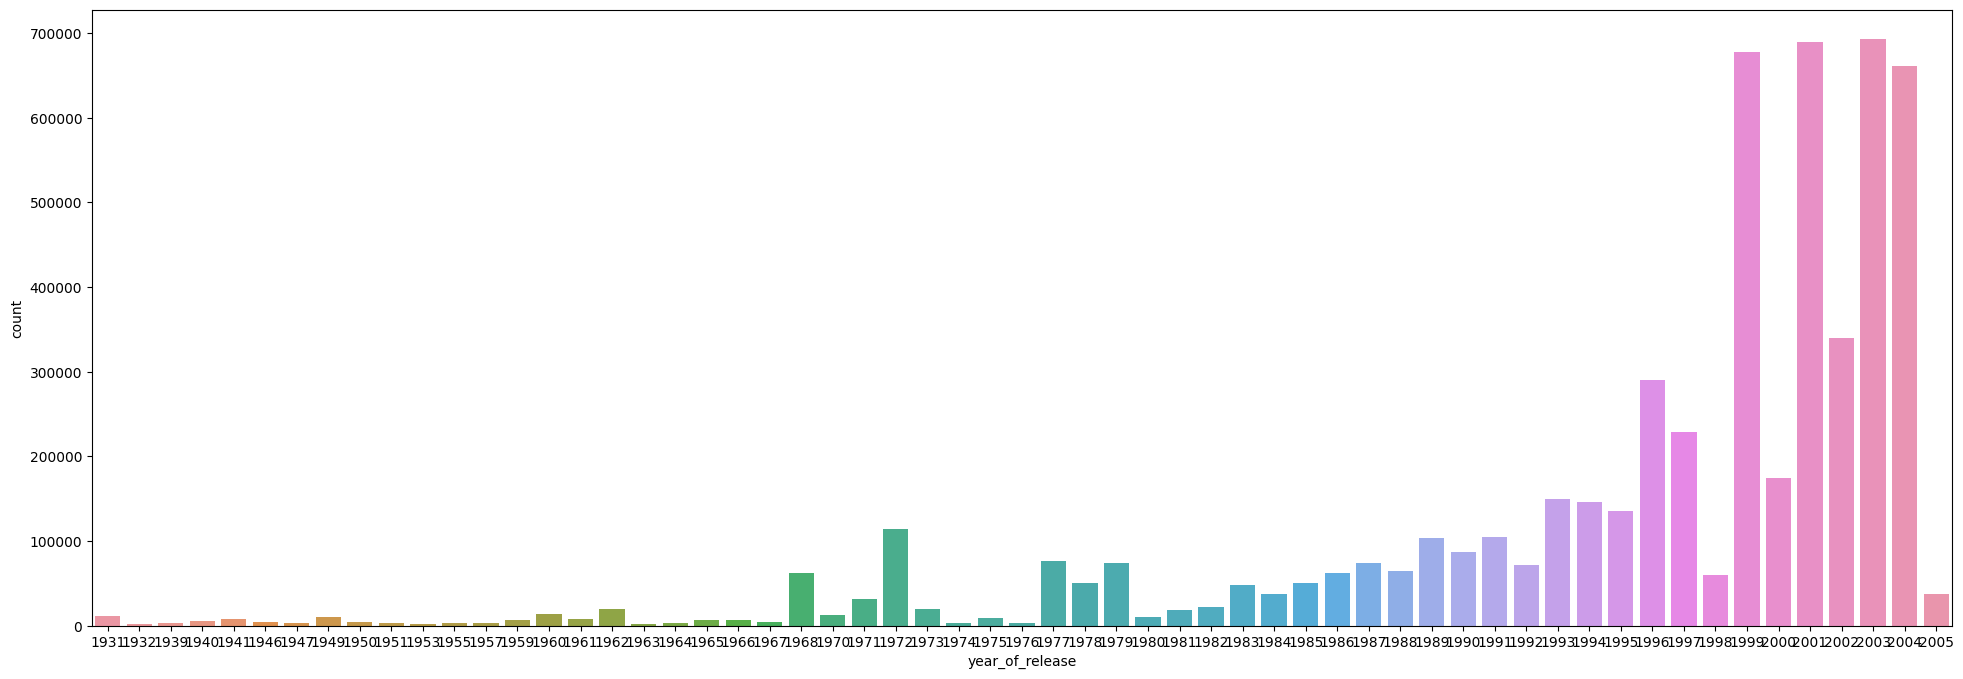

In [93]:
# Count plot of the movies per year release (only the ones that are rated atleast 1000)
filtered = df.groupby('year_of_release').filter(lambda x: x['year_of_release'].count() > 1000)

# Plot
plt.figure(figsize=(24,8))
sns.countplot(x='year_of_release', data=filtered)
plt.show()

Highest numbers of movies were relesed on 2003

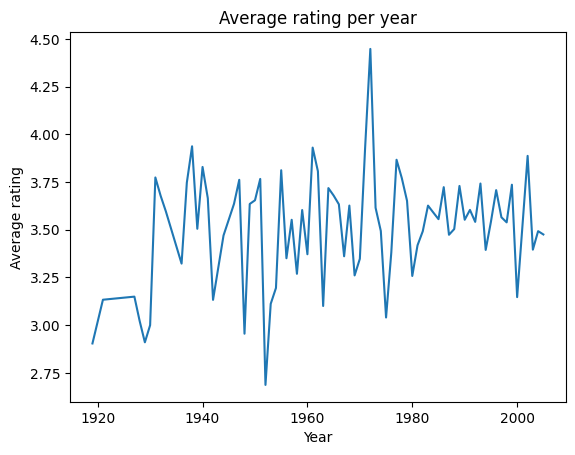

In [94]:
# group the ratings by year and take the mean
ratings_per_year = df.groupby('year_of_release')['rating'].mean()

# plot the average/mean ratings per year
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.title('Average rating per year')
plt.show()

Here we can see that movies from 1970's have higest average ratings.

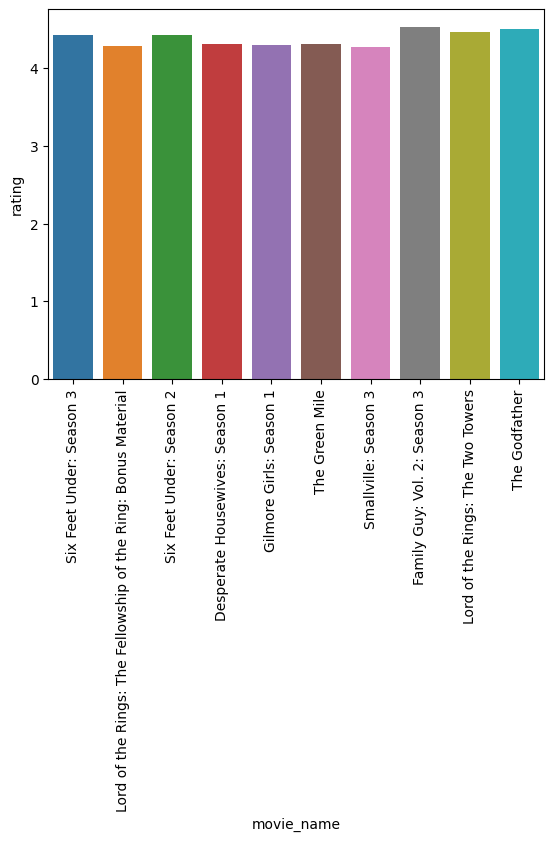

In [95]:
# plotting highly rated top 10 movies among the users based on their mean rating
top_movies = df.groupby('movie_id')['rating'].mean().sort_values(ascending=False)[:10]
top_movies = df.loc[df['movie_id'].isin(top_movies.index)]

sns.barplot(x='movie_name', y='rating', data=top_movies, errorbar=None)
plt.xticks(rotation=90)
plt.show()

Checking the distribution of movies and users in the dataset.

In [98]:
 df['movie_id'].value_counts()

16377    181426
9340     173596
11521    151245
12911    147661
12582    143682
          ...  
7842         56
1858         54
3656         42
15587        37
8858         36
Name: movie_id, Length: 999, dtype: int64

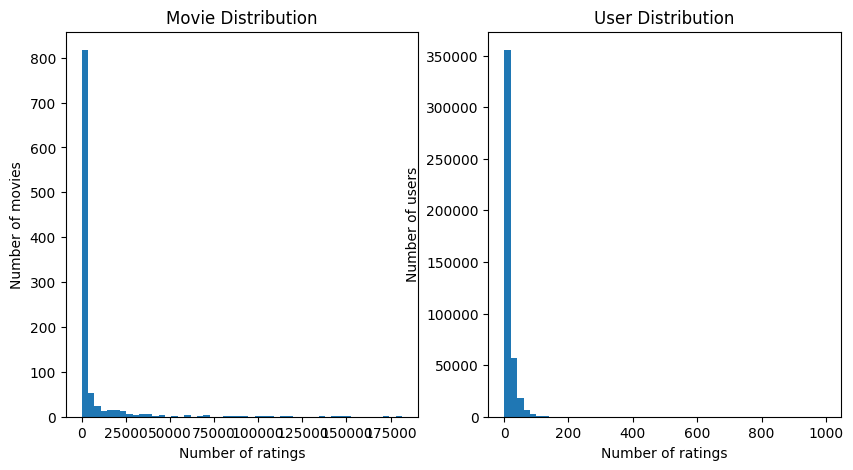

In [20]:
# Count the occurrences of each movie ID and user ID
movie_counts = df['movie_id'].value_counts()
user_counts = df['customer_id'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the movie distribution on the first subplot
axs[0].hist(movie_counts, bins=50)
axs[0].set_title('Movie Distribution')
axs[0].set_xlabel('Number of ratings')
axs[0].set_ylabel('Number of movies')

# Plot the user distribution on the second subplot
axs[1].hist(user_counts, bins=50)
axs[1].set_title('User Distribution')
axs[1].set_xlabel('Number of ratings')
axs[1].set_ylabel('Number of users')

# Show the plot
plt.show()



Here we can see majority of movies are rated once. Also, majority of users rate only one movie.

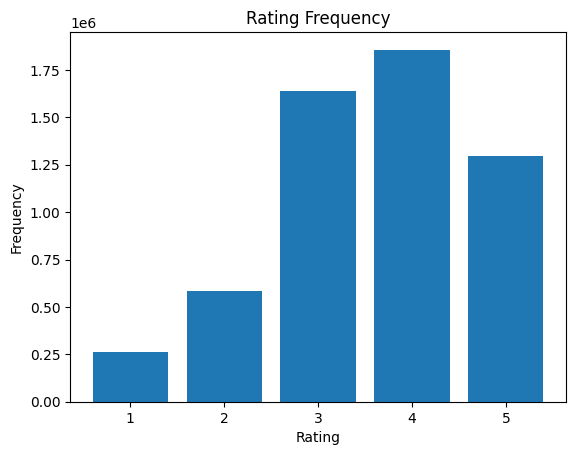

In [99]:
# Checking the distribution of ratings in the dataset.
rating_counts = df['rating'].value_counts()

# Sort the counts by rating value
rating_counts = rating_counts.sort_index()

# Plot the frequency of each rating
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Rating Frequency')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Here we can see the most popular rating is 4

# 4. Test/Train/Validation split

We sample the top 10% of users who have given the most ratings to reduce the data size. We then group the data by movie id, and for each movie id we sample data to create train, test and validation set so that all the movies are included in all three splits.

In [103]:
# Calculate the count of ratings for each user
uer_count_ratings = df.groupby('customer_id')['rating'].count().reset_index()

# Sort the users by their count of rating in descending order
uer_count_ratings = uer_count_ratings.sort_values(by='rating', ascending=False)

# Select the top 10% of users based on their number of rating
n_top_users = int(len(uer_count_ratings) * 0.10)
top_users = uer_count_ratings.head(n_top_users)['customer_id'].values


In [107]:
# checking the length of top users.
len(top_users)

43969

In [108]:
# Create empty lists to hold train, test, and validation data
train_data, test_data, val_data = [], [], []

# Group the dataframe by movie ID and iterate over each group
for movie_id, movie_df in df.groupby('movie_id'):
    movie_df = movie_df[movie_df['customer_id'].isin(top_users)]

    # Split the filtered dataframe into train, test, and validation sets
    train = movie_df.sample(frac=0.8, random_state=200)
    temp = movie_df.drop(train. index)
    test = temp.sample(frac=0.5, random_state=200)
    val = temp.drop(test.index)

    # Check that each set has at least one entry and append them to their respective lists
    if len(train) < 1 or len(test) < 1 or len(val) < 1:
        continue
    train_data.append(train[:100])
    test_data.append(test)
    val_data.append(val)

In [109]:
# combining these smaller DataFrames into larger ones that contain all the training, testing and validation data, respectively
train_df = pd.concat (train_data)
test_df = pd. concat (test_data)
val_df = pd.concat(val_data)

train_df.shape, test_df.shape, val_df.shape

((86119, 6), (230304, 6), (230281, 6))

In [110]:
# checking the length of column in test and train dataframe
len(train_df['movie_id'].unique()), len(test_df['movie_id'].unique()), len(val_df['movie_id'].unique())

(999, 999, 999)

Here we can see that train_df, test_df and val_df has equal number of movies i.e. 999 movies.

# 5. Recommender system using SVD

We have created a movie based SVD Reccomender system. We choose the customer's most recent highest rated movie and recommend top 5 movies based on that to that customer.

To build a recommendation system, we need to transform this tabular data into a matrix where each row represents a user, each column represents a movie, and each entry in the matrix represents the rating given by the user to the movie. This matrix is called a user-item-rating matrix for 'train_df'.All users will not have rated every movie in the dataset, so there will be missing values in the matrix which is replaced by 0.


we can make use of “pivot table” function in pandas to convert df into a required matrixes.

https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/

In [16]:
# transforming 'train_df' into a user-movie matrix
train_matrix = train_df.pivot(index="customer_id", columns="movie_id", values="rating").fillna(0)

In [17]:
train_matrix

movie_id,56,104,106,156,170,199,215,297,311,323,...,17562,17589,17599,17622,17646,17661,17678,17713,17741,17752
customer_id,,,,,,,,,,,,,,,,,,,,,
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2647840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2647908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We also convert test_df and val_df into user-movie matrixes.

In [18]:
# transforming 'test_df' into a user-movie matrix
test_matrix = test_df.pivot(index="customer_id", columns="movie_id", values="rating").fillna(0)

In [19]:
# transforming 'val_df' into a user-movie matrix
val_matrix = val_df.pivot(index="customer_id", columns="movie_id", values="rating").fillna(0)

We create two dictionaries so that it will be easier to map the movie_id from the indexes and indexes from the movie_id.

https://stackoverflow.com/questions/36244380/enumerate-for-dictionary-in-python

In [20]:
# creating two dictionaries 'movie_id2idx' and 'idx2movie_id' which are used to map movie IDs to and from their corresponding indices in the 'train_matrix'
movie_id2idx = {k: v for v, k in enumerate(train_matrix.columns)}
idx2movie_id = {v: k for v, k in enumerate(train_matrix.columns)}

## 5.1 SVD 

Here we define the functions to perform SVD decomposition of data, transform the data with SVD and reconstruct transformed data for evaluation. We also define a function to get the explained variance ratio of the SVD decomposition to pick the correct hyperparameters.

https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

https://github.com/scikit-learn/scikit-learn/blob/9aaed4987/sklearn/decomposition/_truncated_svd.py#L25

In [119]:
from scipy.linalg import svd

# Define a function to perform SVD decomposition on a given matrix X
def svd_decomposition(X, n_elements):
    # Perform SVD decomposition on matrix X
    U, s, VT = svd(X, full_matrices=False) 
    # Select only the first n_elements singular values and their corresponding rows in VT
    s = s[:n_elements]  
    VT = VT[:n_elements, :]
    # Return the left singular vectors (U), singular values (s), and right singular vectors (VT) for the given X matrix
    return U, s, VT 

# Define a function to reconstruct a matrix X given its right singular vectors VT
def svd_reconstruct(X, VT):
    return np.dot(X, VT) # Compute the dot product of X and VT to obtain the reconstructed matrix

# Define a function to transform a matrix X using its right singular vectors VT
def svd_transform(X, VT):
    return np.dot(X, VT.T) # Compute the dot product of X and the transpose of VT to obtain the transformed matrix

# Define a function to compute the explained variance ratio for a  matrix X given the right singular vectors VT
def svd_explained_var_ratio(X, VT):  
    X_transformed = np.dot(X, VT.T) # Transform X using VT to obtain the transformed matrix X_transformed
    exp_var = np.var(X_transformed, axis=0)  # Compute the variance of each column in X_transformed
    full_var = np.var(X, axis=0).sum() # Compute the total variance of X by summing the variances of each column
    return (exp_var / full_var).sum() # Compute the ratio of explained variance to total variance and return the sum of these ratios across all columns in X_transformed

Then we choose the number of components that explains 90% of variance in the data. We use val_df for choosing the number of components. 

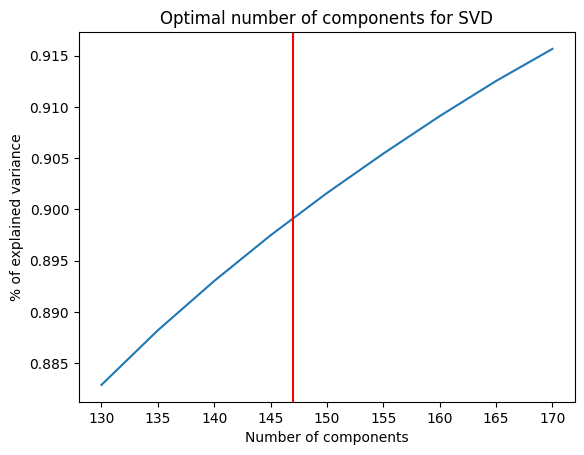

In [120]:
import matplotlib.pylab as plt

# Create empty lists to hold x and y values
x, y = [], []

# calculate the explained variance ratio
for i in range(130, 175, 5):
    U, Sigma, VT = svd_decomposition(val_matrix.values.T, n_elements=i)
    var_explained = svd_explained_var_ratio(val_matrix.values.T, VT)
    y.append(var_explained)
    x.append(i)

#plot
plt.plot(x, y)
plt.axvline(x=147, color='r')
plt.title('Optimal number of components for SVD')
plt.xlabel('Number of components')
plt.ylabel("% of explained variance")
plt.show()

After analyzing the plot of the percentage of explained variance against the number of components, we can say that selecting 147 components can provide an explanation for 90% of the variance in the data. Hence, we select 147 as the optimal number of components.

We then performed SVD decomposition on the train_matrix using the svd_decomposition function we defined earlier then, transform the train matrix using the VT matrix obtained from SVD decomposition to obtain the reduced SVD matrix.

In [113]:
# Perform SVD decomposition on the transpose of the train matrix using 147 components
U, Sigma, VT = svd_decomposition(train_matrix.values.T, n_elements=147)

# Transform the train matrix using the VT matrix obtained from SVD decomposition to obtain the reduced SVD matrix
train_svd_matrix = svd_transform(train_matrix.values.T, VT)
train_svd_matrix.shape

(721, 147)

## 5.2 SVD Recommender system

A function svd_recommend is defined that takes in a customer ID and recommends n(5) movies to that customer based on the similarity of the movies to the ones the customer has already watched, using the cosine similarity measure.

The function first retrieves the customer's viewing history sorted by rating date in descending order. It then selects the movie with the highest rating. Next cosine similarity between the selected movie and all other movies is calulated followed by identification of top 5 movies.

https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/

In [121]:
def svd_recommend(customer_id, train_svd, n=5):

    # defining a function to check similarity between two movie vectors
    def cosine_similarity(v,u):
        return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))

    # retrive the customer viewing history by rating date and higest rating 
    history = df.query(f"customer_id == {customer_id}").sort_values('rating_date', ascending=False)
    
    # Check if user history exists
    if(len(history) == 0):
        print('User history not found')
    else:
        print(history[['movie_name', 'rating', 'rating_date']])
    
    max_rating = history['rating'].max() # Find the maximum rating given by the user in their history
    latest = history[history['rating'] == max_rating].iloc[0] #Retrieve the latest movie that received the maximum rating
    idx = movie_id2idx[latest['movie_id']] # Map the movie id to its index and store the result in 'idx' variable
    
    # Create a list to store similarity scores between the searched movie and all other movies in the train set
    scores = []
    for i in range(train_svd.shape[0]):
        # get similarity score between searched movie and movie i
        score = cosine_similarity(train_svd[idx], train_svd[i])
        scores.append(score)
    
    # Convert scores to a numpy array
    scores = np.array(scores)

    # Sort the scores in descending order and get the indices of the top n movies
    topn = (-scores).argsort()[1:n+1]

    # Print the movie name of the recommended movies
    print('-----------------------------------------------------------------------')
    print('Recommended Movies based on the customers latest and highest ratings:')
    print('-----------------------------------------------------------------------')
    for i in topn:
        a = idx2movie_id[i]
        print(a, df[df['movie_id']==a].iloc[0]['movie_name'])



In [122]:
# Checking the recommendation for customer_id 10 based on the movies he/ she rated
svd_recommend(10, train_svd_matrix)

                                    movie_name  rating rating_date
5085924  Austin Powers: The Spy Who Shagged Me       5  2005-08-08
620847                                 Gothika       2  2005-05-16
1130005                            Vanilla Sky       2  2004-06-13
1507130                       2 Fast 2 Furious       2  2003-12-30
5195512                       Anger Management       4  2003-12-30
4722267           The Kid Stays in the Picture       3  2003-12-13
4850254                               Hoosiers       3  2003-10-01
3221210                    Along Came a Spider       4  2003-01-03
3701130                        Double Jeopardy       4  2002-12-31
3095700                         The Green Mile       4  2002-12-27
2539559                           Pearl Harbor       5  2002-12-20
-----------------------------------------------------------------------
Recommended Movies based on the customers latest and highest ratings:
------------------------------------------------------

## 5.3 Performance evaluation of SVD Recommender system

To evaluate the performance of the SVD based recommener, we transform the test dataset to dimensionality reduced SVD matrix. Then, we transform the SVD matrix back to original form which represents our predictions. To compute evaluation metric, we use RMSE between original matrix and prediction matrix.

In [167]:
# Perform SVD decomposition on the test matrix and transform it
U, Sigma, VT_test = svd_decomposition(test_matrix.values.T, n_elements=147)
test_svd_matrix = svd_transform(test_matrix.values.T, VT_test)

# Calculate mean squared error between the original test matrix and the reconstructed matrix using the SVD
mse = np.mean((test_matrix.T.values - svd_reconstruct(test_svd_matrix, VT_test))**2)
mse

0.005228500976751439

# 6. Recommender system using KNN 

We now create a user-similarity based KNN Reccomender system. Initially, we do dimentinality reduction of user_movie_matrix using SVD. Then we create a cosine similarity matrix between all users represented in the SVD martix. Then to get the nearest neighbors for a particular user, we compute the similarity score between the user and all the other users in the SVD matrix. Then to recommend movies to the user, we select movies that were rated highly (>3) by the neighbors.

In [123]:
# Creating a sparse matrix
user_movie_matrix = train_df.pivot(index="customer_id", columns="movie_id", values="rating").fillna(0)
user_movie_matrix

movie_id,56,67,104,106,156,170,199,215,286,297,...,17609,17622,17646,17660,17661,17678,17713,17741,17750,17752
customer_id,,,,,,,,,,,,,,,,,,,,,
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
user_movie_matrix.shape

(29163, 999)

## 6.1 SVD

In [125]:
# Performing SVD on the user-joke matrix
U, s, VT = svd_decomposition(user_movie_matrix.values, n_elements=147)
user_movie_matrix_svd = svd_transform(user_movie_matrix.values, VT)
user_movie_matrix_svd.shape


(29163, 147)

## 6.2 KNN

https://campus.datacamp.com/courses/building-recommendation-engines-in-python/collaborative-filtering?ex=10

In [133]:
from sklearn.metrics.pairwise import cosine_similarity
# compute pairwise similarity matrix of all the users in the user_movie_matrix_svd.
similarities = cosine_similarity(user_movie_matrix_svd)

# put the similarity scores in a dataframe.
cosine_similarity_df = pd.DataFrame(similarities, index = user_movie_matrix.index, columns = user_movie_matrix.index)
cosine_similarity_df

customer_id,79,1276,1310,1333,1427,1442,1457,1527,1611,1626,...,2648853,2648869,2648885,2649027,2649093,2649120,2649257,2649267,2649285,2649296
customer_id,,,,,,,,,,,,,,,,,,,,,
79,1.000000,0.009729,-0.039889,-0.004312,-0.016905,0.259369,-0.016556,-0.041879,-0.025036,-0.062922,...,-0.088139,0.114429,0.056533,-0.027571,0.040045,-0.002987,-0.056678,0.012334,0.072714,-0.012892
1276,0.009729,1.000000,0.046195,-0.133384,-0.030356,-0.165355,-0.030064,-0.032960,-0.028118,0.100042,...,0.107692,0.009548,-0.038326,0.086550,0.019229,-0.068176,0.037501,0.029191,0.136394,0.038849
1310,-0.039889,0.046195,1.000000,0.047025,-0.016567,-0.046444,0.066930,0.159181,-0.013810,0.019258,...,0.033282,-0.073268,-0.065547,0.018702,-0.031903,-0.030219,0.040504,-0.033614,-0.029016,0.133438
1333,-0.004312,-0.133384,0.047025,1.000000,-0.003867,-0.070258,0.018205,0.105999,0.056477,0.014297,...,0.017082,0.090332,-0.036119,0.035229,0.028061,0.059193,0.009959,-0.028212,0.040918,-0.040843
1427,-0.016905,-0.030356,-0.016567,-0.003867,1.000000,-0.022794,-0.043346,0.009470,0.131448,-0.009858,...,0.078513,-0.027272,0.044054,0.000878,-0.039908,-0.017070,0.054881,-0.002627,-0.041256,-0.042094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649120,-0.002987,-0.068176,-0.030219,0.059193,-0.017070,0.062825,-0.032596,0.057430,-0.038546,-0.034906,...,0.016540,-0.030326,-0.048894,0.085909,0.091478,1.000000,-0.091800,-0.055084,0.290339,-0.055175
2649257,-0.056678,0.037501,0.040504,0.009959,0.054881,0.103132,-0.030393,0.107279,0.389718,0.101607,...,0.060489,0.282559,0.024633,0.051124,0.166602,-0.091800,1.000000,0.024267,-0.061876,0.005694
2649267,0.012334,0.029191,-0.033614,-0.028212,-0.002627,0.085366,0.006647,-0.060249,0.015781,-0.035901,...,-0.100307,-0.085374,0.269422,0.015581,-0.031757,-0.055084,0.024267,1.000000,0.160388,0.023388


To evaluate the performance of this model we generate prediction ratings for each users based on their nearest neighbours. Then we compute MSE score to get evaluation metrix.

In [150]:
def knn_evaluate(df, n):
    # create user_movie matrix from the dataframe.
    user_movie_matrix = df.pivot(index="customer_id", columns="movie_id", values="rating").fillna(0)
    # keep track of index in the matrix to cusotmer id using a dict.
    idx2user_id = {v: k for v, k in enumerate(user_movie_matrix.index)}
    # do SVD decomposition on user_movie matrix.
    U, Sigma, VT_test = svd_decomposition(user_movie_matrix.values, n_elements=147)
    # get transformed matrix from the SVD.
    user_movie_matrix_svd = svd_transform(user_movie_matrix.values, VT_test)

    pred_matrix = []
    # now iterate over all the users in the user_movie_matrix to create predictions.
    for i, r in user_movie_matrix.iterrows():
        ratings = r.values
        # indexes of movies rated by this user.
        rated_idxs = np.where(ratings != 0)[0]

        # get vector of this using SVD.
        ratings_svd = svd_transform(ratings.reshape((1, -1)), VT_test)
        
        # compute similarity score of this user against all the users.
        user_similarity = np.dot(ratings_svd, user_movie_matrix_svd.T).flatten()

        # get the n users with largest similarity.
        neighbors = (-user_similarity).argsort()[:n]
        # get customer ids from the indices of the neighbor.

        user_idxs = [idx2user_id[n] for n in neighbors]
        # get all the ratings for each neighbors.
        neighbor_ratings = user_movie_matrix.loc[user_idxs].values[:,rated_idxs]
        predicted_ratings = []
        # iterate over each movie (columns)
        for col_idx in range(neighbor_ratings.shape[1]):
            # get indices of the rated movies i.e. ignore 0s
            non_zero_indices = np.nonzero(neighbor_ratings[:, col_idx])[0]
            if len(non_zero_indices) == 0:
                predicted_ratings.append(0)
            else:
                # predicted rating is the mean of rating for this movie by all the neighbors.
                pred = np.mean(neighbor_ratings[:, col_idx][non_zero_indices])
                predicted_ratings.append(pred)
        pred_ratings = np.zeros(VT_test.shape[1])
        # put the predicted ratings in appropriates indices.
        np.put(pred_ratings, rated_idxs, predicted_ratings)
        pred_matrix.append(pred_ratings)

    # finally compute RMSE between original ratings vs. predicted ratings based on neighbors.
    mse = np.mean((user_movie_matrix.values - np.array(pred_matrix))**2)
    return mse

To pick the optimal number of nearest neighbour for our model we plot the MSE with different values of nearest neighbours. We observe that MSE decreses sharply till 200 nearest neighnbours and then platues. Therefoure, we chose 200 as the optimal nearest neighbours using validation dataset.

100%|██████████| 7/7 [33:57<00:00, 291.10s/it]


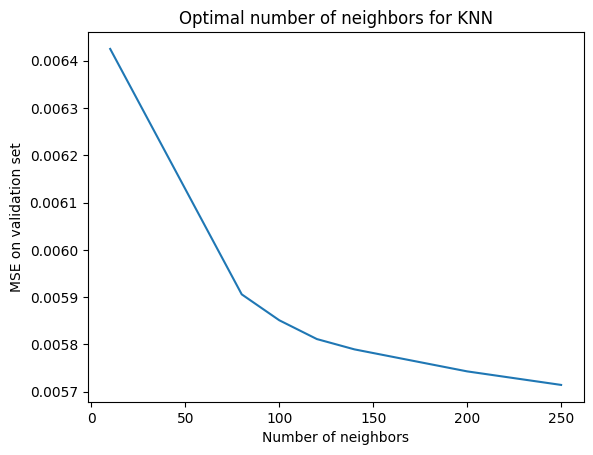

In [161]:
# Get the best value for hyperparameter "n neighbors" by computing MSE for a range of values using validation set.
x, y = [], []
for n in tqdm([10, 80, 100, 120, 140, 200, 250]):
    mse = knn_evaluate(val_df, n=n)
    y.append(mse)
    x.append(n)

plt.plot(x, y)
plt.axvline(x=200, color='r')
plt.title('Optimal number of neighbors for KNN')
plt.xlabel('Number of neighbors')
plt.ylabel("MSE on validation set")
plt.show()

We define a function to recommend movies using our KNN user similarity model.

In [162]:
# Recommender system using KNN
def knn_recommend(customer_id, n):
    user_rated_m = user_movie_matrix.loc[customer_id]
    rated_joke_ids = user_rated_m[user_rated_m > 0].index.tolist()
    # using similarity df to find the nearest neighbour
    user_similarity_series = cosine_similarity_df.loc[customer_id].sort_values(ascending=False)
    user_idxs = user_similarity_series[1:n+1].index.tolist()
    # creating a set to store the indexes of movies that have been rated highly by the customer's nearest neighbors
    movie_ids = set()
    # select the highest ratings made by nearest neighbor and adding it to movie_ids.
    for userId in user_idxs:
        ratings = user_movie_matrix.loc[userId]
        ratings = ratings[ratings > 3].index.values
        for id in ratings:
            movie_ids.add(id)
    print('------------------------------------------')
    print('Recommended jokes based on similar users:')
    print('------------------------------------------')
    for movieid in list(movie_ids)[:5]:
        if movieid not in rated_joke_ids:
            print(movieid, df[df['movie_id']==movieid].iloc[0]['movie_name'])

In [163]:
# Checking recommendations for user based on the similar users ratings
knn_recommend(1276, n=200)

------------------------------------------
Recommended jokes based on similar users:
------------------------------------------
10240 Summer Catch
7171 Milo
13836 Mulan 2
5645 Repossessed
7694 Witchboard


## 6.3 Performance evaluation of KNN Recommender system

In [164]:
# Finally compute the MSE score using the test set using the same evaluation function as above.
knn_evaluate(test_df, n=200)

0.005753628647341499

# 7. Conclusion

In this notebook we developed two different models for movie recommendations. The first model used SVD to perform dimentionality reduction on user movie ratings data and recommended new movies to the user based on higest similarity of the users highest and latest rated movie.

Similarly, In the second model we performed SVD on the dataset and recommended new movies to the user based on user similarity using KNN method. We got n closet neighnour of the user based on their ratings history and provided recommendation based on the negibours heigest rated movies.

We used MSE to evaluate both of these models. While the MSE scores are very close the SVD movie similarity model slightly out performend the knn similarity model.

In conclusion, We recommend using both movie similarity and user similarity methods to provide a diverse set of recommendation to the users.